In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
query = '''SELECT r.rental_date,
       COUNT(r.rental_id) AS rental_count,
       SUM(p.amount) AS total_paid,
       SUM(p.amount) / COUNT(r.rental_id) AS average_payment_per_rental,
       f.film_id,
       f.title,
       f.rental_rate,
       f.length,
       f.rating,
       f.special_features,
       f.release_year,
       film_rentals.total_rentals_per_film,
       CASE WHEN MONTH(r.rental_date) = 5 AND YEAR(r.rental_date) = 2005 THEN 1 ELSE 0 END AS rented_in_may
FROM sakila.film AS f
JOIN sakila.inventory AS i ON f.film_id = i.film_id
JOIN sakila.rental AS r ON i.inventory_id = r.inventory_id
JOIN sakila.payment AS p ON r.rental_id = p.rental_id
JOIN (
    SELECT f.film_id, COUNT(r.rental_id) AS total_rentals_per_film
    FROM sakila.film AS f
    JOIN sakila.inventory AS i ON f.film_id = i.film_id
    JOIN sakila.rental AS r ON i.inventory_id = r.inventory_id
    GROUP BY f.film_id
) AS film_rentals ON f.film_id = film_rentals.film_id
GROUP BY r.rental_date, f.film_id, f.title, f.rental_rate, f.length, f.rating, f.special_features, f.release_year;'''

data = pd.read_sql_query(query, engine)
data.head()

,rental_date,rental_count,total_paid,average_payment_per_rental,film_id,title,rental_rate,length,rating,special_features,release_year,total_rentals_per_film,rented_in_may
0,2005-07-08 19:03:15,1,0.99,0.99,1,ACADEMY DINOSAUR,0.99,86,PG,"Deleted Scenes,Behind the Scenes",2006,23,0
1,2005-08-02 20:13:10,1,3.99,3.99,1,ACADEMY DINOSAUR,0.99,86,PG,"Deleted Scenes,Behind the Scenes",2006,23,0
2,2005-08-21 21:27:43,1,3.99,3.99,1,ACADEMY DINOSAUR,0.99,86,PG,"Deleted Scenes,Behind the Scenes",2006,23,0
3,2005-05-30 20:21:07,1,1.99,1.99,1,ACADEMY DINOSAUR,0.99,86,PG,"Deleted Scenes,Behind the Scenes",2006,23,1
4,2005-06-17 20:24:00,1,0.99,0.99,1,ACADEMY DINOSAUR,0.99,86,PG,"Deleted Scenes,Behind the Scenes",2006,23,0


In [3]:
data.shape

(16030, 13)

In [4]:
data.dtypes

rental_date                   datetime64[ns]
rental_count                           int64
total_paid                           float64
average_payment_per_rental           float64
film_id                                int64
title                                 object
rental_rate                          float64
length                                 int64
rating                                object
special_features                      object
release_year                           int64
total_rentals_per_film                 int64
rented_in_may                          int64
dtype: object

In [5]:
data['rented_in_may'] = data['rented_in_may'].astype(bool)

In [6]:
data.isna().sum()

rental_date                   0
rental_count                  0
total_paid                    0
average_payment_per_rental    0
film_id                       0
title                         0
rental_rate                   0
length                        0
rating                        0
special_features              0
release_year                  0
total_rentals_per_film        0
rented_in_may                 0
dtype: int64

In [7]:
data['title'].value_counts()

BUCKET BROTHERHOOD     34
ROCKETEER MOTHER       33
GRIT CLOCKWORK         32
RIDGEMONT SUBMARINE    32
FORWARD TEMPLE         32
                       ..
PRIVATE DROP            5
BRAVEHEART HUMAN        5
HARDLY ROBBERS          4
TRAIN BUNCH             4
MIXED DOORS             4
Name: title, Length: 958, dtype: int64

In [8]:
def clean_column_lowercase(df, column_name):
    df[column_name] = df[column_name].str.lower()
    return df

In [9]:
cleaned_df = clean_column_lowercase(data, 'title')

In [10]:
data['title'].value_counts()

bucket brotherhood     34
rocketeer mother       33
grit clockwork         32
ridgemont submarine    32
forward temple         32
                       ..
private drop            5
braveheart human        5
hardly robbers          4
train bunch             4
mixed doors             4
Name: title, Length: 958, dtype: int64

In [11]:
data['rating'].value_counts()

PG-13    3581
NC-17    3287
PG       3212
R        3178
G        2772
Name: rating, dtype: int64

In [12]:
cleaned_df = clean_column_lowercase(data, 'rating')

In [13]:
data['special_features'].value_counts()

Trailers,Commentaries,Behind the Scenes                   1318
Trailers                                                  1150
Trailers,Commentaries                                     1140
Trailers,Behind the Scenes                                1136
Behind the Scenes                                         1114
Commentaries,Deleted Scenes,Behind the Scenes             1112
Commentaries                                              1099
Commentaries,Behind the Scenes                            1092
Trailers,Deleted Scenes                                   1063
Deleted Scenes,Behind the Scenes                          1048
Deleted Scenes                                            1037
Commentaries,Deleted Scenes                               1020
Trailers,Commentaries,Deleted Scenes,Behind the Scenes     999
Trailers,Commentaries,Deleted Scenes                       922
Trailers,Deleted Scenes,Behind the Scenes                  780
Name: special_features, dtype: int64

In [14]:
def modify_special_features(df, column_name):
    df[column_name] = df[column_name].apply(lambda x: True if x else False)
    return df

In [15]:
modified_df = modify_special_features(cleaned_df, 'special_features')

In [16]:
modified_df['special_features'].value_counts()

True    16030
Name: special_features, dtype: int64

In [17]:
def alter_rental_date(df, column_name):
    df[column_name] = pd.to_datetime(df[column_name]).dt.date
    return df

In [18]:
altered_df = alter_rental_date(modified_df, 'rental_date')

In [19]:
altered_df.head(50)

,rental_date,rental_count,total_paid,average_payment_per_rental,film_id,title,rental_rate,length,rating,special_features,release_year,total_rentals_per_film,rented_in_may
0,2005-07-08,1,0.99,0.99,1,academy dinosaur,0.99,86,pg,True,2006,23,False
1,2005-08-02,1,3.99,3.99,1,academy dinosaur,0.99,86,pg,True,2006,23,False
2,2005-08-21,1,3.99,3.99,1,academy dinosaur,0.99,86,pg,True,2006,23,False
3,2005-05-30,1,1.99,1.99,1,academy dinosaur,0.99,86,pg,True,2006,23,True
4,2005-06-17,1,0.99,0.99,1,academy dinosaur,0.99,86,pg,True,2006,23,False
5,2005-07-07,1,0.99,0.99,1,academy dinosaur,0.99,86,pg,True,2006,23,False
6,2005-07-30,1,1.99,1.99,1,academy dinosaur,0.99,86,pg,True,2006,23,False
7,2005-08-23,1,1.99,1.99,1,academy dinosaur,0.99,86,pg,True,2006,23,False
8,2005-07-31,1,0.99,0.99,1,academy dinosaur,0.99,86,pg,True,2006,23,False
9,2005-08-22,1,0.99,0.99,1,academy dinosaur,0.99,86,pg,True,2006,23,False


In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/var/folders/h1/sm0yz6nx7m9cgsn8627qx6c00000gn/T/ipykernel_66309/187203700.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix=data.corr(method='pearson')


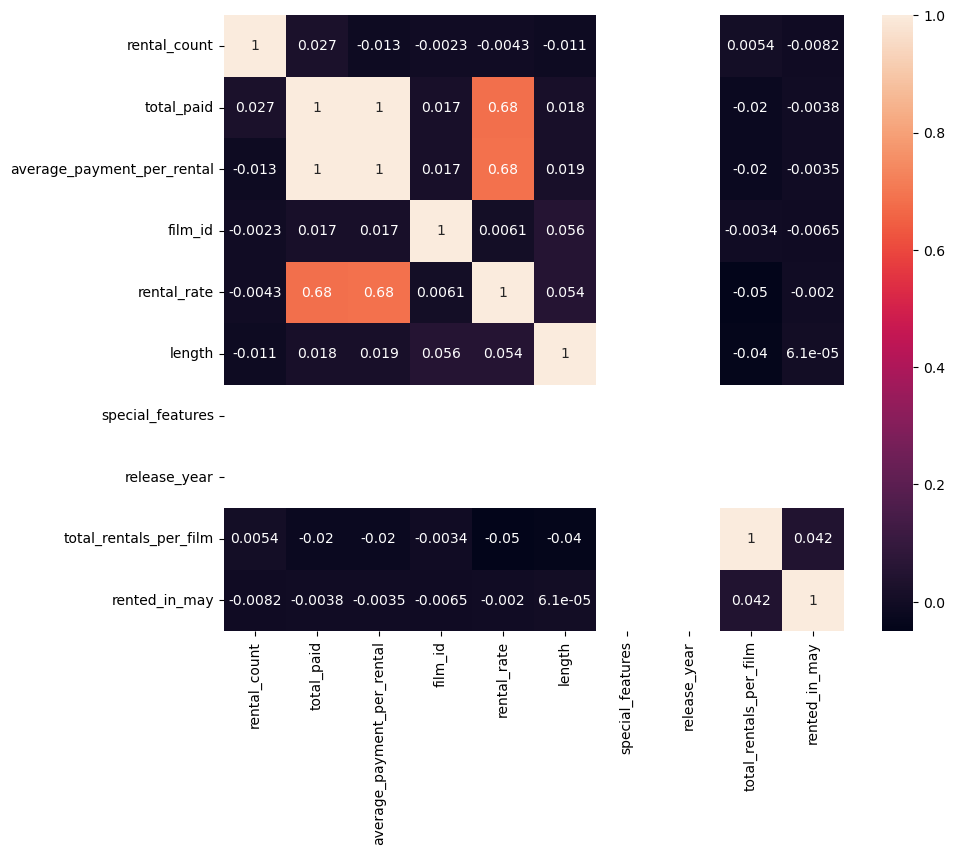

In [21]:
corr_matrix=data.corr(method='pearson') 
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [23]:
cleaned_data = altered_df

In [24]:
cleaned_data.head()

,rental_date,rental_count,total_paid,average_payment_per_rental,film_id,title,rental_rate,length,rating,special_features,release_year,total_rentals_per_film,rented_in_may
0,2005-07-08,1,0.99,0.99,1,academy dinosaur,0.99,86,pg,True,2006,23,False
1,2005-08-02,1,3.99,3.99,1,academy dinosaur,0.99,86,pg,True,2006,23,False
2,2005-08-21,1,3.99,3.99,1,academy dinosaur,0.99,86,pg,True,2006,23,False
3,2005-05-30,1,1.99,1.99,1,academy dinosaur,0.99,86,pg,True,2006,23,True
4,2005-06-17,1,0.99,0.99,1,academy dinosaur,0.99,86,pg,True,2006,23,False


In [25]:
y = cleaned_data['rented_in_may']
X = cleaned_data.drop(['rented_in_may'], axis=1)

In [26]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [28]:
import numpy as np

In [29]:
X_train_df = pd.DataFrame(X_train, columns=X.columns)
X_test_df  = pd.DataFrame(X_test,  columns=X.columns)

X_train_num = X_train_df.select_dtypes(include = np.number)
X_test_num  = X_test_df.select_dtypes(include = np.number)
X_train_cat = X_train_df.select_dtypes(['object'])
X_test_cat  = X_test_df.select_dtypes(['object'])

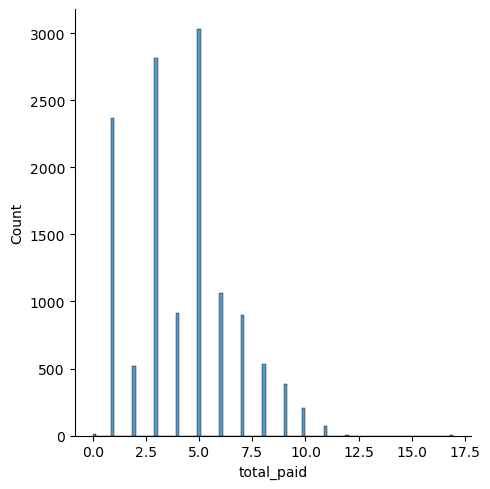

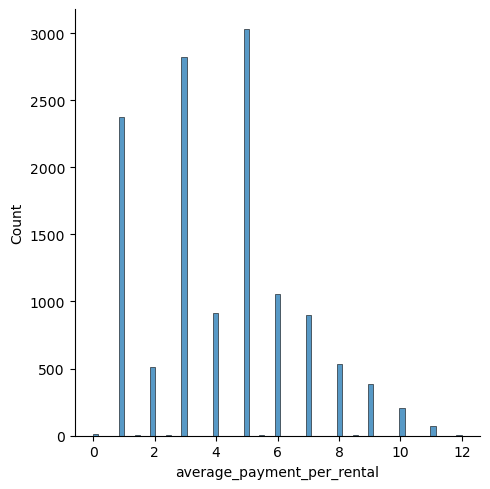

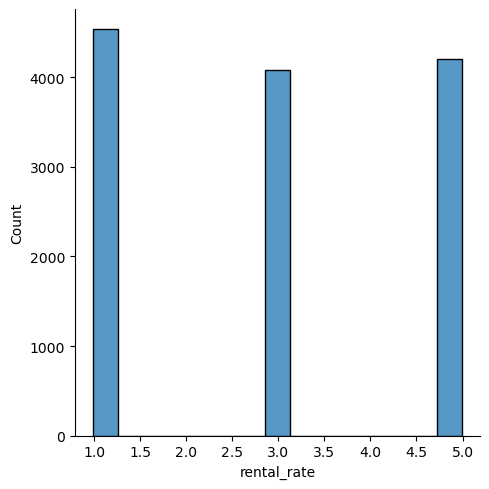

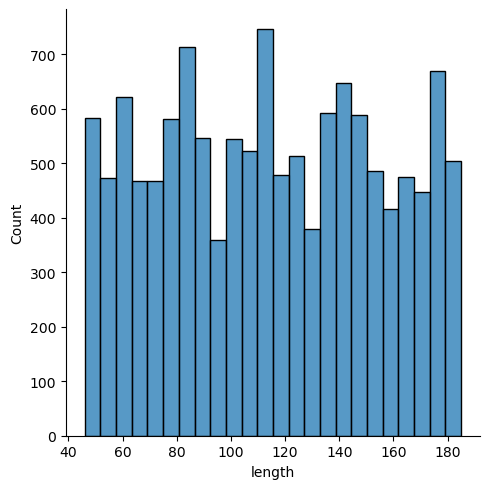

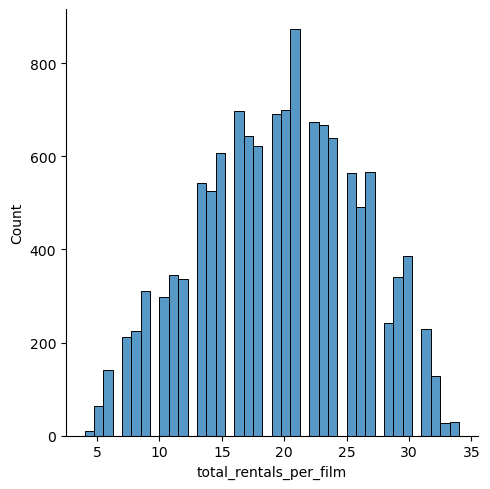

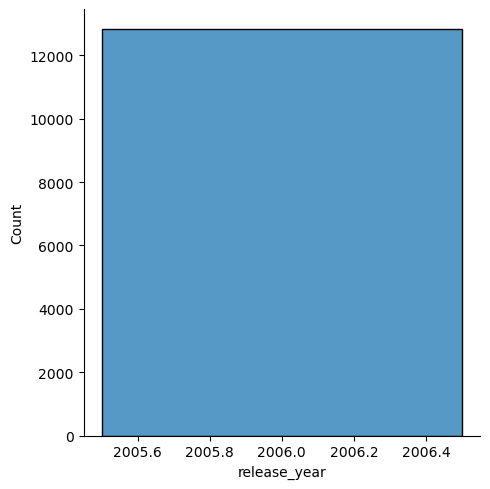

In [30]:
sns.displot(X_train_num['total_paid'])
plt.show()

sns.displot(X_train_num['average_payment_per_rental'])
plt.show()

sns.displot(X_train_num['rental_rate'])
plt.show()

sns.displot(X_train_num['length'])
plt.show()

sns.displot(X_train_num['total_rentals_per_film'])
plt.show()

sns.displot(X_train_num['release_year'])
plt.show()

In [31]:
import pickle
from sklearn.preprocessing import PowerTransformer

transformer = PowerTransformer()
transformer.fit(X_train_num)

X_train_transformed = transformer.transform(X_train_num)
X_test_transformed  = transformer.transform(X_test_num)
X_train_transformed_df = pd.DataFrame(X_train_transformed, columns=X_train_num.columns)
X_test_transformed_df  = pd.DataFrame(X_test_transformed,  columns=X_test_num.columns)
X_train_transformed_df.head()

,rental_count,total_paid,average_payment_per_rental,film_id,rental_rate,length,release_year,total_rentals_per_film
0,0.0,-0.409185,-0.408957,-0.107655,0.147879,0.295055,0.001953,-2.249805
1,0.0,0.443126,0.444057,-0.919936,1.183268,-1.296842,0.001953,-0.071434
2,0.0,-0.925856,-0.925622,0.563121,-1.229121,0.740661,0.001953,0.712957
3,0.0,0.810445,0.811921,-0.719740,1.183268,0.945802,0.001953,-0.697033
4,0.0,-1.549020,-1.548266,-1.326491,-1.229121,-0.070543,0.001953,0.712957


In [33]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(drop=None)
encoder.fit(X_train_cat)

X_train_cat_encoded = encoder.transform(X_train_cat).toarray()

#np.sparse() ~ np.array() optimized for memory. It only saves the location of the non-null entries.
# Color -> color_R, color_G
# Brand -> brand_A, brand_B, brand_C,....

#pd.DataFrame(X_train_cat_encoded, columns=X_train_cat.columns)

#cols = encoder.get_feature_names(input_features=X_train_cat.columns)
# Note: in version 1.0 and higher of sklearn this method is called 'get_feature_names_out()'
# we will reuse encoder and cols when encoding the X_test_cat
X_train_encoded_df = pd.DataFrame(X_train_cat_encoded, columns=encoder.get_feature_names_out())
X_train_encoded_df.head()

,rental_date_2005-05-24,rental_date_2005-05-25,rental_date_2005-05-26,rental_date_2005-05-27,rental_date_2005-05-28,rental_date_2005-05-29,rental_date_2005-05-30,rental_date_2005-05-31,rental_date_2005-06-14,rental_date_2005-06-15,...,title_young language,title_youth kick,title_zhivago core,title_zoolander fiction,title_zorro ark,rating_g,rating_nc-17,rating_pg,rating_pg-13,rating_r
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [34]:
X_train_treated_df = pd.concat([X_train_transformed_df, X_train_encoded_df], axis=1)
X_train_treated_df

,rental_count,total_paid,average_payment_per_rental,film_id,rental_rate,length,release_year,total_rentals_per_film,rental_date_2005-05-24,rental_date_2005-05-25,...,title_young language,title_youth kick,title_zhivago core,title_zoolander fiction,title_zorro ark,rating_g,rating_nc-17,rating_pg,rating_pg-13,rating_r
0,0.0,-0.409185,-0.408957,-0.107655,0.147879,0.295055,0.001953,-2.249805,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.443126,0.444057,-0.919936,1.183268,-1.296842,0.001953,-0.071434,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,-0.925856,-0.925622,0.563121,-1.229121,0.740661,0.001953,0.712957,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.810445,0.811921,-0.719740,1.183268,0.945802,0.001953,-0.697033,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,-1.549020,-1.548266,-1.326491,-1.229121,-0.070543,0.001953,0.712957,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12819,0.0,0.443126,0.444057,0.888038,0.147879,-1.041107,0.001953,0.555892,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12820,0.0,0.443126,0.444057,0.089358,1.183268,1.169737,0.001953,0.398916,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12821,0.0,0.443126,0.444057,1.233679,0.147879,0.923183,0.001953,0.870108,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
12822,0.0,-0.409185,-0.408957,-0.138341,0.147879,0.625115,0.001953,-0.228009,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [35]:
X_train_treated_df.describe()

,rental_count,total_paid,average_payment_per_rental,film_id,rental_rate,length,release_year,total_rentals_per_film,rental_date_2005-05-24,rental_date_2005-05-25,...,title_young language,title_youth kick,title_zhivago core,title_zoolander fiction,title_zorro ark,rating_g,rating_nc-17,rating_pg,rating_pg-13,rating_r
count,1.282400e+04,1.282400e+04,1.282400e+04,1.282400e+04,1.282400e+04,1.282400e+04,12824.000000,1.282400e+04,12824.000000,12824.000000,...,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000,12824.000000
mean,9.523123e-20,7.036722e-17,-2.939355e-16,-7.757017e-17,9.253013e-17,3.631946e-16,0.001953,-1.396263e-16,0.000390,0.008422,...,0.000234,0.000390,0.000546,0.000858,0.002027,0.172255,0.205240,0.199080,0.224813,0.198612
std,3.250315e-18,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,1.000039e+00,0.000000,1.000039e+00,0.019743,0.091386,...,0.015294,0.019743,0.023358,0.029276,0.044983,0.377617,0.403893,0.399324,0.417475,0.398971
min,0.000000e+00,-2.372866e+00,-2.370371e+00,-2.157094e+00,-1.229121e+00,-1.841812e+00,0.001953,-2.403691e+00,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,-4.091851e-01,-4.089574e-01,-7.786213e-01,-1.229121e+00,-8.212270e-01,0.001953,-6.970334e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000e+00,4.049061e-02,4.098644e-02,8.935787e-02,1.478788e-01,2.826862e-02,0.001953,8.524907e-02,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000e+00,4.431264e-01,4.440572e-01,8.675859e-01,1.183268e+00,8.550661e-01,0.001953,7.129569e-01,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.110223e-16,3.709482e+00,2.578834e+00,1.563443e+00,1.183268e+00,1.649084e+00,0.001953,2.287868e+00,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [36]:
from sklearn.linear_model import LogisticRegression

classification = LogisticRegression(random_state=0, solver='lbfgs',
                  multi_class='ovr')

classification.fit(X_train_treated_df, y_train)

LogisticRegression(multi_class='ovr', random_state=0)

In [37]:
X_test_transformed_df.head()

,rental_count,total_paid,average_payment_per_rental,film_id,rental_rate,length,release_year,total_rentals_per_film
0,0.0,-0.409185,-0.408957,0.056447,0.147879,0.198848,0.001953,-1.786220
1,0.0,-0.409185,-0.408957,0.734797,0.147879,1.476768,0.001953,0.085249
2,0.0,1.150018,1.152113,0.295801,0.147879,1.125271,0.001953,-1.164849
3,0.0,-1.549020,-1.548266,0.212773,-1.229121,1.147524,0.001953,-1.164849
4,0.0,1.150018,1.152113,0.858804,1.183268,0.945802,0.001953,-0.540815


In [38]:
encoded_test_cat = encoder.transform(X_test_cat).toarray()
onehot_encoded_test_df = pd.DataFrame(encoded_test_cat, columns=encoder.get_feature_names_out())
onehot_encoded_test_df.head()

,rental_date_2005-05-24,rental_date_2005-05-25,rental_date_2005-05-26,rental_date_2005-05-27,rental_date_2005-05-28,rental_date_2005-05-29,rental_date_2005-05-30,rental_date_2005-05-31,rental_date_2005-06-14,rental_date_2005-06-15,...,title_young language,title_youth kick,title_zhivago core,title_zoolander fiction,title_zorro ark,rating_g,rating_nc-17,rating_pg,rating_pg-13,rating_r
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [39]:
X_test_treated_df = pd.concat([X_test_transformed_df, onehot_encoded_test_df], axis=1)

In [40]:
y_train_pred = classification.predict(X_train_treated_df)
y_test_pred  = classification.predict(X_test_treated_df)
print("The first predictions on the TRAIN set are: ",y_train_pred[:10])
print("The first predictions on the TEST set are: ",y_test_pred[:10])

The first predictions on the TRAIN set are:  [False False  True False False False False False False False]
The first predictions on the TEST set are:  [False False False False False False False False False False]


In [43]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, f1_score, cohen_kappa_score

In [44]:
print("The confusion matrix on the TRAIN set is: ")
cm_train = confusion_matrix(y_train, y_train_pred)
cm_train

The confusion matrix on the TRAIN set is: 


array([[11897,     0],
       [    5,   922]])

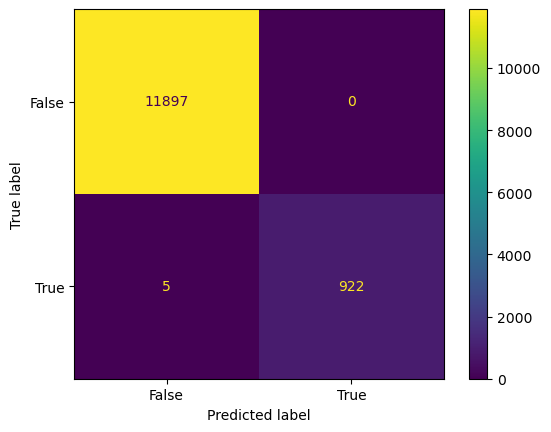

In [45]:
disp = ConfusionMatrixDisplay(cm_train, display_labels=classification.classes_);
disp.plot()
plt.show()

The confusion matrix on the TEST set is: 
[[2977    0]
 [   3  226]]


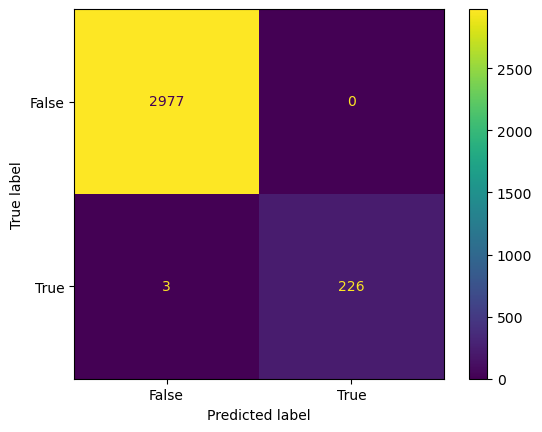

In [46]:
print("The confusion matrix on the TEST set is: ")
cm_test = confusion_matrix(y_test, y_test_pred)
print(cm_test)
disp = ConfusionMatrixDisplay(cm_test,display_labels=classification.classes_);
disp.plot()
plt.show()

In [47]:
y_train.value_counts()

False    11897
True       927
Name: rented_in_may, dtype: int64

In [48]:
print("The accuracy in the TRAIN set is: {:.3f}".format(accuracy_score(y_train, y_train_pred)))
print("The accuracy in the TEST  set is: {:.3f}".format(accuracy_score(y_test, y_test_pred)))

The accuracy in the TRAIN set is: 1.000
The accuracy in the TEST  set is: 0.999


In [49]:
print("The precission in the TRAIN set is: {:.3f}".format(48335/(48335+6309)))
print("The precission in the TEST  set is: {:.3f}".format(12112/(12112+1564)))

The precission in the TRAIN set is: 0.885
The precission in the TEST  set is: 0.886


In [50]:
print("The recall in the TRAIN set is: {:.3f}".format(48335/(48335+400)))
print("The recall in the TEST  set is: {:.3f}".format(12112/(12112+90)))

The recall in the TRAIN set is: 0.992
The recall in the TEST  set is: 0.993


In [53]:
print("The F1-score for the TEST set is {:.2f}".format(f1_score(y_test,y_test_pred, pos_label=True)))

The F1-score for the TEST set is 0.99


In [55]:
print(classification_report(y_train, y_train_pred,target_names=['True','False']))

              precision    recall  f1-score   support

        True       1.00      1.00      1.00     11897
       False       1.00      0.99      1.00       927

    accuracy                           1.00     12824
   macro avg       1.00      1.00      1.00     12824
weighted avg       1.00      1.00      1.00     12824



In [56]:
print(classification_report(y_test, y_test_pred,target_names=['True','False']))

              precision    recall  f1-score   support

        True       1.00      1.00      1.00      2977
       False       1.00      0.99      0.99       229

    accuracy                           1.00      3206
   macro avg       1.00      0.99      1.00      3206
weighted avg       1.00      1.00      1.00      3206



In [57]:
y_test_np = np.array(y_test)
len(list(y_test_np[y_test_np == 'True']))

/var/folders/h1/sm0yz6nx7m9cgsn8627qx6c00000gn/T/ipykernel_66309/3036802311.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  len(list(y_test_np[y_test_np == 'True']))


0

In [58]:
2977 + 229

3206

In [59]:
from sklearn.metrics import cohen_kappa_score

In [60]:
cohen_kappa_score(y_train, y_train_pred)

0.9970857443814224

In [61]:
y_train.value_counts()

False    11897
True       927
Name: rented_in_may, dtype: int64

In [63]:
(y_train.value_counts()[True]-y_train.value_counts()[False])/((y_train.value_counts()[True]+y_train.value_counts()[False]))

-0.8554273237679352

In [64]:
11897/(11897+927)

0.9277136618839675